In [1]:

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
import os
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'korea-datathon-2019'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id
# Authenticate user
auth.authenticate_user()


ModuleNotFoundError: No module named 'google'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
import scipy
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import Utils
%reload_ext autoreload
%autoreload 2
        
class SkipConnection (nn.Module):
    def __init__(self,in_channel,out_channel,keep_dim=True):
        super(SkipConnection,self).__init__()

        if in_channel != out_channel:
            self.conv1d = nn.Conv1d(in_channel,out_channel,1)
        initialize_weights(self)
    def forward(self,before,after):
        '''
        :param before: the tensor before passing convolution blocks
        :param after: the tensor of output from convolution blocks
        :return: the sum of inputs
        '''
        if before.shape[2] != after.shape[2]: # if the length is different (1/2)
            before = nn.functional.max_pool1d(before,2,2)

        if before.shape[1] != after.shape[1]:
            before = self.conv1d(before)
        return before + after
    
class ResidualBlock (nn.Module):
    def __init__(self,in_channel,out_channel,pool=False,kernel_size=15,
                 activation=nn.LeakyReLU(),do=0.5):
        super(ResidualBlock,self).__init__()
        self.pool = pool
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_channel),
            activation,
            nn.Dropout(do),
            nn.Conv1d(in_channel,out_channel, kernel_size,1,kernel_size // 2),
            nn.BatchNorm1d(out_channel),
            activation,
            nn.Dropout(do),
            nn.Conv1d(out_channel,out_channel, kernel_size,1,kernel_size // 2)
        )
        self.skip = SkipConnection(in_channel,out_channel)
        initialize_weights(self)
        
    def forward(self, input):  
        out = self.block(input)
        if self.pool:
            out = nn.functional.max_pool1d(out,2,2)
        out = self.skip(input,out)

        return out


class ResidualEncoder (nn.Module):
    def __init__(self,seq_length, num_channel,kernel_size,
                 do,activation):
        assert (kernel_size//2)%2, print('kernel_size//2 must be odds')

        super(ResidualEncoder,self).__init__()
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        self.conv1st = nn.Sequential(
            nn.Conv1d(1,self.num_channel,self.kernel_size,1,self.kernel_size//2),
            nn.BatchNorm1d(self.num_channel)
        )
        
        self.block_info = [
            # in channel , out channel, on/off max_pooling_mode, kernel_size
            (self.num_channel,self.num_channel,1,self.kernel_size),
            (self.num_channel,self.num_channel,0,self.kernel_size),
            (self.num_channel,self.num_channel,1,self.kernel_size),
            (self.num_channel,self.num_channel,0,self.kernel_size),
            (self.num_channel,self.num_channel*2,1,self.kernel_size),
            (self.num_channel*2,self.num_channel*2,0,self.kernel_size),
            (self.num_channel*2,self.num_channel*2,1,self.kernel_size//2),
            (self.num_channel*2,self.num_channel*2,0,self.kernel_size//2),
            (self.num_channel*2,self.num_channel*3,1,self.kernel_size//2),
            (self.num_channel*3,self.num_channel*3,0,self.kernel_size//2),
            (self.num_channel*3,self.num_channel*3,1,self.kernel_size//2),
            (self.num_channel*3,self.num_channel*3,0,self.kernel_size//2),
        ]
        
        self.pool_count = 0
        for ch_info in self.block_info:
            self.pool_count +=ch_info[2]
       
        self.output_size = seq_length
        
        for i in range(self.pool_count):
            self.output_size = self.output_size//2
  
        
        
        self.encoder = nn.Sequential()
        for i,(in_ch,out_ch,max_pooling_mode,kernel_size) in enumerate(self.block_info):
            self.encoder.add_module('residual_block_{}'.format(i),
                                    ResidualBlock(in_ch,out_ch,max_pooling_mode,kernel_size,activation,do))
        initialize_weights(self)
        
    def forward(self,input):
        out = self.conv1st(input)
        out = self.encoder(out)
        return out


class ResidualNetHDI(nn.Module): #
    def __init__(self,seq_length,kernel_size,
                 num_channel, 
                 class_num,
                 do=0.5,activation=nn.LeakyReLU()):
        
        super(ResidualNetHDI,self).__init__()
        self.seq_length = seq_length  # the number of points of a wave form 
        self.num_channel = num_channel
        self.kernel_size = kernel_size 
        self.class_num = class_num
        
        self.encoder = ResidualEncoder(self.seq_length,
                                self.num_channel, #channel 
                                   self.kernel_size,
                                   do,activation)
        
        
        self.bn = nn.BatchNorm1d(num_channel*3)
        self.out_size = self.encoder.output_size
        self.flatten_len = self.out_size*self.num_channel*3
        self.linear = torch.nn.Sequential(
            nn.Linear(self.flatten_len,32),
            nn.LeakyReLU(),
            nn.Dropout(do),            
          #  nn.Linear(self.hid_size , self.n_classes), # second layer
         #   nn.Softmax(dim=1), 
        )
       # self.soft_max = nn.Softmax(1)
        initialize_weights(self)
        
    def forward(self,x): # x : a set of lists consisting of wave forms
        out = self.encoder(x)
        out = self.linear(out.view(-1,self.flatten_len))
        #out = self.soft_max(out)
        return out
    
class HDIClassifier (nn.Module):
    def __init__(self,num_wave,seq_len_list,kernel_list,class_num):
        self.seq_len_list=seq_len_list
        super(HDIClassifier, self).__init__()
        
        self.ecg = ResidualNetHDI(seq_len_list[0],kernel_list[0],num_channel = 5,class_num=2)
        self.eeg = ResidualNetHDI(seq_len_list[1],kernel_list[0],num_channel = 5,class_num=2)
        self.abp = ResidualNetHDI(seq_len_list[2],kernel_list[0],num_channel = 5,class_num=2)
        
        
        self.mlp = torch.nn.Sequential(
            nn.Linear(32*num_wave,16),
            nn.Linear(16 , class_num), 
            nn.Softmax(dim=1), 
        )
        initialize_weights(self)
         
    def forward(self,x): 
        out0 = self.ecg(x[:,:self.seq_len_list[0]].view(-1,1,self.seq_len_list[0]))
        out1 = self.eeg(x[:,self.seq_len_list[0]:self.seq_len_list[0]+self.seq_len_list[1]].view(-1,1,self.seq_len_list[1]))
        out2 = self.abp(x[:,-self.seq_len_list[2]:].view(-1,1,self.seq_len_list[2]))
        
        y_hat = self.mlp(torch.cat((out0,out1,out2),1))
        return y_hat
    
def initialize_weights(net):
    torch.manual_seed(1)
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
           # print(m.weight.data)      
        

In [4]:
ecg_train = pd.read_csv('ecg_training.csv',index_col=0) #5000
eeg_train = pd.read_csv('eeg_training.csv',index_col=0) #2560
art_train = pd.read_csv('art_training.csv',index_col=0) #5000

ecg_test = pd.read_csv('ecg_test.csv',index_col=0)
eeg_test = pd.read_csv('eeg_test.csv',index_col=0)
art_test = pd.read_csv('art_test.csv',index_col=0)

In [5]:
full_trainig_set = pd.concat([ecg_train.iloc[:,:-2],eeg_train.iloc[:,:-2],art_train],axis=1)
full_trainig_set = full_trainig_set.dropna()

full_test_set = pd.concat([ecg_test.iloc[:,:-2],eeg_test.iloc[:,:-2],art_test],axis=1)
full_tset_set = full_test_set.dropna()

- Input shape - 
Training: (20, 12560) (20,) || Test: (20, 12560) (20,)
++++++++++++++++++++++++++++++++++++++++++++++++++
Model name: HDIClassifier
Model on Host memory
0th loss: 0.69,     0th loss:0.69 Complete! Training time: 11.346 sec
Testing...    Complete! Testing time: 2.638 sec
--------------------------------------------------
### Results: 
201909220251
0.047619047619047616
    0  1
0   1  0
1   1  0
2   1  0
3   1  0
4   1  0
5   1  0
6   1  0
7   1  0
8   1  0
9   1  0
10  0  1
11  1  0
12  1  0
13  1  0
14  1  0
15  1  0
16  1  0
17  1  0
18  1  0
19  1  0
AUC Ranking!
1 HDIClassifier 0.632


Average Precision Ranking!
1 HDIClassifier 0.125


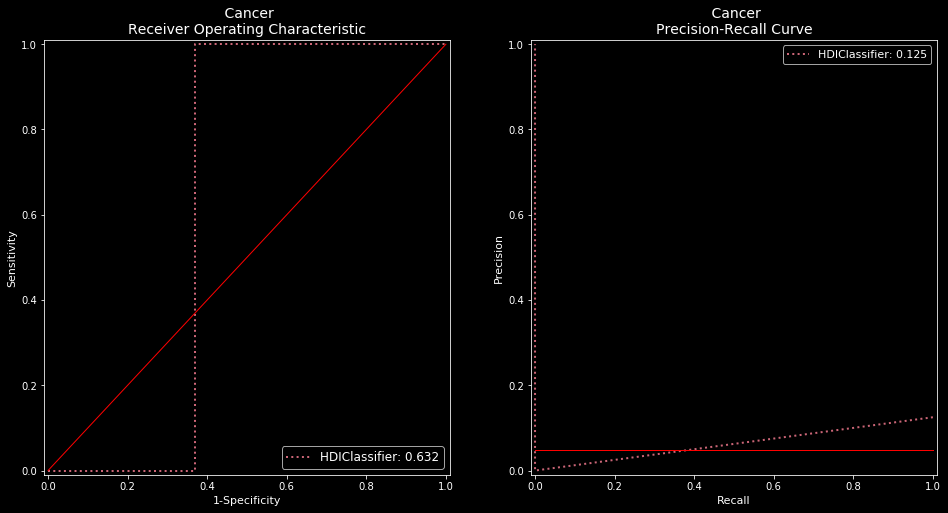

In [55]:
HDI_cls = HDIClassifier(3,[5000,2560,5000],[15,7,15],class_num=2)
tmp_result = {}
tmp_result.update(Utils.perform_deep (full_trainig_set.iloc[:,:-2].values, full_trainig_set.iloc[:,-1].values, 
                                 full_test_set.iloc[:,:-2].values, full_test_set.iloc[:,-1].values, 
                               [HDI_cls], bat_size=256, epoch=1,lr=0.002)
)
Utils.evaluation(full_test_set.iloc[:,-1].values, tmp_result)


In [ ]:
Utils.evaluation(full_tset_set.iloc[:,-1:], tmp_result)